In [1]:
import torch
print(torch.__version__)


2.8.0+cu128


[エポック 1, バッチ 100] 損失: 2.301
[エポック 1, バッチ 200] 損失: 2.292
[エポック 1, バッチ 300] 損失: 2.280
[エポック 1, バッチ 400] 損失: 2.259
[エポック 1, バッチ 500] 損失: 2.225
[エポック 1, バッチ 600] 損失: 2.142
[エポック 1, バッチ 700] 損失: 1.883
[エポック 1, バッチ 800] 損失: 1.271
[エポック 1, バッチ 900] 損失: 0.793
テストデータの正解率: 83.98%
予測: 7 2 1 0 4 1 9 9 5
正解: 7 2 1 0 4 1 4 9 5


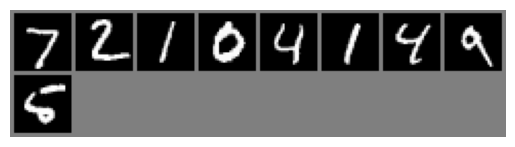

In [11]:
# PyTorchと必要なライブラリをインポートします
import torch  # PyTorchの基本モジュール
import torch.nn as nn  # ニューラルネットワーク用のモジュール
import torch.optim as optim  # 最適化アルゴリズム用モジュール
import torchvision  # データセットやモデルの補助機能が入っている
import torchvision.transforms as transforms  # 画像の前処理（変換）用
import matplotlib.pyplot as plt  # 結果をグラフや画像で表示するためのライブラリ
import numpy as np

# 画像データをテンソルに変換し、正規化する前処理を設定します
transform = transforms.Compose([
    transforms.ToTensor(),  # 画像をPyTorchのテンソルに変換
    transforms.Normalize((0.5,), (0.5,))  # 平均0.5、標準偏差0.5で正規化（ピクセル値調整）
])

# 手書き数字データセットMNISTをダウンロードして準備します（訓練用）
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)  # バッチごとにランダムに読み込む

# 同じくテストデータも準備します（評価用）
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)  # シャッフルしないで読み込む


# 簡単なCNNモデルを定義します
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 1チャネル（白黒）画像、6個の畳み込みフィルターで特徴を抽出
        self.conv1 = nn.Conv2d(1, 6, 3)  # 3x3のフィルター
        self.pool = nn.MaxPool2d(2, 2)  # 2x2の最大プーリングでサイズ半分に圧縮
        self.conv2 = nn.Conv2d(6, 16, 3)  # 6チャネル→16チャネルに変換
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 全結合層1：16チャネル×5×5の特徴マップを120個に縮約
        self.fc2 = nn.Linear(120, 84)  # 全結合層2：120個→84個に変換
        self.fc3 = nn.Linear(84, 10)  # 出力層：84個→10クラス（数字0~9）

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 畳み込み→ReLU活性化→プーリング
        x = self.pool(torch.relu(self.conv2(x)))  # 同じ操作を2回目の畳み込み層に適用
        x = x.view(-1, 16 * 5 * 5)  # 特徴マップを1次元に展開（フラット化）
        x = torch.relu(self.fc1(x))  # 全結合層1で活性化
        x = torch.relu(self.fc2(x))  # 全結合層2で活性化
        x = self.fc3(x)  # 最終出力（クラススコア）
        return x
        
# 1. GPU(cuda)が使えるかチェックし、使える場合はデバイスをcudaに設定。使ええない場合はCPUをそのまま使用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. # ネットワークのインスタンス化と、モデルをGPUに移す（deviceに送る）
net = SimpleCNN().to(device)

# 損失関数と最適化アルゴリズムを設定します
criterion = nn.CrossEntropyLoss()  # 多クラス分類の標準損失関数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 確率的勾配降下法を使用

# モデルを1エポックだけ訓練してみます

for epoch in range(1):  # 繰り返し回数を1回に設定（慣れるための簡単な例）

    running_loss = 0.0  # 損失をためる変数を用意

    #for i, data in enumerate(trainloader, 0):  # データをバッチ単位で取り出す
    # 3. DataLoaderから取り出した入力データとラベルもGPUに移すように修正
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)  # ここが重要！

        optimizer.zero_grad()  # 前回の勾配を0にリセット

        outputs = net(inputs)  # # GPU上で計算、モデルに画像を通して予測値を計算
        loss = criterion(outputs, labels)  # 予測と正解の差（損失）を計算
        loss.backward()  # 損失の逆伝播で勾配を計算
        optimizer.step()  # 勾配に従ってパラメータを更新（学習）

        running_loss += loss.item()  # 現在の損失を追加

        if i % 100 == 99:  # 100バッチごとに表示
            print(f'[エポック {epoch + 1}, バッチ {i + 1}] 損失: {running_loss / 100:.3f}')
            running_loss = 0.0  # 損失をリセット

# 学習済みモデルでテストデータの正解率を計算します
correct = 0
total = 0
with torch.no_grad():  # 評価時は勾配計算を止める
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)# GPUに転送
        outputs = net(images)  # モデルで予測
        _, predicted = torch.max(outputs, 1)  # 最も確率が高いクラスを取得
        total += labels.size(0)  # 全画像数を加算
        correct += (predicted == labels).sum().item()  # 正解数を加算

accuracy = 100 * correct / total  # 正解率をパーセントで計算
print(f'テストデータの正解率: {accuracy:.2f}%')

# ある画像の予測結果を可視化してみましょう
dataiter = iter(testloader)  # テストデータから1バッチ取り出す. イテレータに変換
images, labels = next(dataiter)  # ここで次のバッチを取り出す（タプル）
#images, labels = dataiter.__next__()  # イテレータのメソッドを直接呼ぶ
"""
next(dataiter) は (画像のテンソル, ラベルのテンソル) のタプル（2つの要素のセット、つまりリストのようなもの）を返します。
しかし .to(device) はテンソルに対して使うメソッドなので、タプル全体に対して使えずエラーになります。
"""
images = images.to(device)       # 画像だけGPUに移す
labels = labels.to(device)       # ラベルもGPUに移す

outputs = net(images)  # 予測を計算
_, predicted = torch.max(outputs, 1)  # 最も可能性の高いクラスを取得

images = images.cpu() # GPUからCPUに戻す
# 画像を表示する関数。正解ラベルと予測ラベルを一緒に表示
def imshow(img):
    img = img / 2 + 0.5  # 正規化を戻す
    npimg = img.numpy()  # テンソルをnumpy配列に変換
    npimg = np.transpose(npimg, (1, 2, 0))  # (C, H, W) → (H, W, C) に変換
    plt.imshow(npimg, cmap='gray') # cmap='gray'は白黒画像用（カラーなら不要）
    plt.axis('off')  # 軸を非表示に

# 最初の9枚の画像と予測結果を表示
imshow(torchvision.utils.make_grid(images[:9]))
print('予測:', ' '.join(f'{p.item()}' for p in predicted[:9]))
print('正解:', ' '.join(f'{l.item()}' for l in labels[:9]))

plt.show()  # 画像を画面に表示
